In [23]:
import tensorflow as tf 
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import tensorflow_probability as tfp
import os 
from scipy import signal


In [24]:
#move up in directory
os.chdir('../')

In [82]:
os.getcwd()

'C:\\Users\\deniz\\Desktop\\PhD'

# Globals

In [25]:
# Define the bandit environment (reward distribution)
true_action_values = [0.9, 0.1]  # True values of two actions
N_ACTIONS = 2
N_HIDDEN = 48

In [64]:
print(tf.random.uniform([1], seed=1))  # generates 'A1'
print(tf.random.uniform([1], seed=1))  # generates 'A2'

tf.Tensor([0.1689806], shape=(1,), dtype=float32)
tf.Tensor([0.7539084], shape=(1,), dtype=float32)


In [65]:
print(tf.random.uniform([1], seed=1))  # generates 'A1'
print(tf.random.uniform([1], seed=1))  # generates 'A2'

tf.Tensor([0.4243431], shape=(1,), dtype=float32)
tf.Tensor([0.92531705], shape=(1,), dtype=float32)


# Model Class

In [114]:
# Define the Actor-Critic LSTM model
class ActorCriticLSTM(tf.keras.Model):
    def __init__(self, n_actions, n_hidden, critic_weight = 0.05, 
                 random_seed = 1234, name='a2c', chkpt_dir='saved_weights'):
        
        super(ActorCriticLSTM, self).__init__()
        
        # define attributes
        self.n_actions = n_actions
        self.n_hidden = n_hidden
        self.critic_weight = critic_weight
        self.gamma = gamma
        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name)
        self.random_seed = random_seed
        
        # define random seed
        tf.random.set_seed(self.random_seed)
        
        # define architecture
        self.lstm = tf.keras.layers.LSTM(self.n_hidden)
        self.actor = tf.keras.layers.Dense(self.n_actions, activation='softmax')  # Two possible actions
        self.critic = tf.keras.layers.Dense(1)

    def call(self, prev_reward, prev_action):
        oh = tf.one_hot(prev_action, depth=N_ACTIONS, dtype=tf.float32)
        inputs = tf.concat([prev_reward, oh], 1)
        inputs = tf.expand_dims(inputs, 0)
        x = self.lstm(inputs)
        return self.actor(x), self.critic(x)
    
    # Discounting function used to calculate discounted returns. -> but is not needed, as all rewards in an episode are equally important
    def discount(x, gamma):
        return signal.lfilter([1], [1, -gamma], x[::-1], axis=0)[::-1]
    
    def learn(self, rewards, actions):
        
        with tf.GradientTape() as tape:
            
            # previous rewards
            prev_rewards = np.append(0, rewards[:-1]) # insert initial 0 reward
            prev_rewards = tf.convert_to_tensor(prev_rewards, dtype=tf.float32)
            prev_rewards = tf.reshape(prev_rewards, [-1, 1])
    
            # previous actions
            prev_actions = np.append(N_ACTIONS, actions[:-1]) # insert initial action (results in 0-vector in oh)
            prev_actions = tf.convert_to_tensor(prev_actions, dtype=tf.int32)
            
            # Get action probabilities and critic values from the model
            action_probs, critic_values = self.call(prev_rewards, prev_actions)

            # Calculate advantage
            advantages = tf.reshape(rewards, [-1,1]) - critic_values

            # Calculate actor and critic losses
            actor_loss = -tf.reduce_sum(tf.math.log(action_probs) * tf.one_hot(actions, depth=self.n_actions) * advantages)
            critic_loss = tf.reduce_sum(tf.square(advantages))

            # Calculate the total loss
            total_loss = actor_loss + self.critic_weight * critic_loss

            # Apply gradients to update the model
            gradients = tape.gradient(total_loss, self.trainable_variables)
            optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        return(total_loss, critic_loss, gradients)
        
    def save(self):
        print('... saving weights ...')
        self.save_weights(self.checkpoint_file)

    def load(self):
        print('... loading weights ...')
        self.load_weights(self.checkpoint_file)
        

# Bandit Class

In [115]:
# Bandit environment simulation
def bandit_step(action):
    # Simulate the bandit environment by sampling rewards based on the chosen action
    reward = [0.0,1.0][action]
    return reward

# Training loop

In [148]:
# Initialize the model
model = ActorCriticLSTM(n_actions=N_ACTIONS, n_hidden=N_HIDDEN)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0007)

# Training loop
num_episodes = 10
max_steps_per_episode = 10

In [149]:
# setup tensorboard
path_to_save_progress = 'tensorboard1/'

# create folder to save progress
if not os.path.exists(path_to_save_progress):
    os.makedirs(path_to_save_progress)

summary_writer        = tf.summary.create_file_writer(path_to_save_progress  + str('TEST'))

# training loop
for episode in range(num_episodes):
    # Reset the environment and collect data
    actions, rewards = [], []
    prev_reward = tf.convert_to_tensor([[0.0]])
    prev_action = tf.convert_to_tensor([N_ACTIONS]) # initial action results in zero vector one-hot encoding

    for step in range(max_steps_per_episode):
        # Choose an action using the actor's policy
        action_probs, _ = model(prev_reward, prev_action)
        action = np.random.choice(N_ACTIONS, p=action_probs.numpy()[0])

        # Interact with the bandit environment
        reward = bandit_step(action)

        # Store data for training
        actions.append(action)
        rewards.append(reward)
        
    prev_reward = tf.convert_to_tensor([[reward]], dtype=tf.float32)
    prev_action = tf.convert_to_tensor([action], dtype=tf.int32)

    # learn

    total_loss, critic_loss, gradients = model.learn(rewards, actions)

    # collect metric for tensorboard
    
    mean_rewards = np.mean(rewards)
    is_switch = [int(actions[t] != actions[t-1]) for t in range(1, len(actions))]
    is_switch = np.append(np.nan, is_switch)
    mean_switch = np.nanmean(is_switch)
    grad_norm = tf.linalg.global_norm(gradients)
    
    with summary_writer.as_default():
        tf.summary.scalar('Losses/Critic Loss', critic_loss, step=episode)
        tf.summary.scalar('Losses/Total Loss', total_loss, step=episode)
        tf.summary.scalar('Diagnostics/Gradient Norm', grad_norm, step=episode)
        tf.summary.scalar('Behaviour/Rewards per Episode', mean_rewards, step=episode)
        tf.summary.scalar('Behaviour/Switch Rate per Episode', mean_switch, step=episode)
        summary_writer.flush()
    
# save weights after training
model.save()

    
    

... saving weights ...


In [144]:
grad_norm.numpy

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=17.12441>>

In [111]:
action_probs.numpy()[0]

array([nan, nan], dtype=float32)

[1, 1, 0, 0, 0, 1, 1, 0, 0]

In [99]:
[int(df.choice[t] != df.choice[t-1]) for t in range(1, len(df['choice']))]

0.9

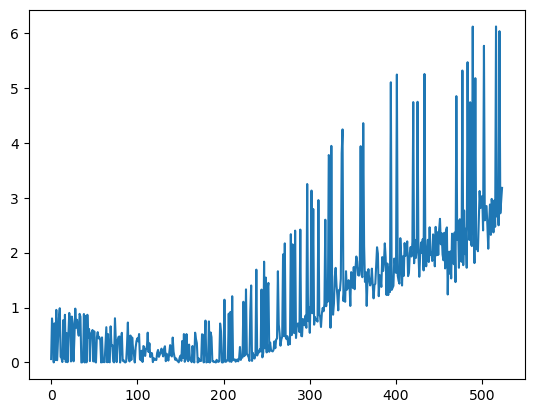

In [12]:
plt.plot(cl)

In [40]:
_

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9342773]], dtype=float32)>

In [38]:
action_probs

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[9.994796e-01, 5.203811e-04]], dtype=float32)>

In [39]:
actions

[0]

In [38]:
oh = tf.one_hot([4], depth=N_ACTIONS)
oh

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 0.]], dtype=float32)>

In [34]:
rew = tf.expand_dims(rewards,1)
rew

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[1.0326908 ],
       [0.80481625],
       [0.10167595],
       [0.18838264],
       [1.0566427 ],
       [0.9085259 ],
       [0.96507436],
       [0.9619041 ],
       [0.3477176 ],
       [0.9088691 ]], dtype=float32)>

In [35]:
tf.concat([rew, oh], 1)

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[1.0326908 , 0.        , 1.        ],
       [0.80481625, 0.        , 1.        ],
       [0.10167595, 1.        , 0.        ],
       [0.18838264, 1.        , 0.        ],
       [1.0566427 , 0.        , 1.        ],
       [0.9085259 , 0.        , 1.        ],
       [0.96507436, 0.        , 1.        ],
       [0.9619041 , 0.        , 1.        ],
       [0.3477176 , 1.        , 0.        ],
       [0.9088691 , 0.        , 1.        ]], dtype=float32)>

In [ ]:
# Save the weights to a file
model.save_weights('trained_weights.h5')  # You can choose any file name and path


In [24]:
import tensorflow as tf
import numpy as np

# Define the Actor-Critic LSTM model
class ActorCriticLSTM(tf.keras.Model):
    def __init__(self):
        super(ActorCriticLSTM, self).__init__()
        self.lstm = tf.keras.layers.LSTM(32)
        self.actor = tf.keras.layers.Dense(2, activation='softmax')  # Two possible actions
        self.critic = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = self.lstm(inputs)
        return self.actor(x), self.critic(x)

# Simulate a call to build the model's weights
# You can use dummy data to initialize the weights, as the exact input is not important for this purpose
dummy_input = np.random.rand(1, 1, 1).astype(np.float32)  # Example dummy input
dummy_input = tf.convert_to_tensor(dummy_input, dtype=tf.float32)
_ = model(dummy_input)  # This initializes the model's weights

# Load the trained weights
model.load_weights('trained_weights.h5')
# Define the bandit environment (reward distribution)
true_action_values = [0.1, 0.9]  # True values of two actions

# Bandit environment simulation
def bandit_step(action):
    # Simulate the bandit environment by sampling rewards based on the chosen action
    reward = np.random.normal(true_action_values[action], 0.1)  # Add noise for realism
    return reward

# Testing loop
num_episodes = 10

for episode in range(num_episodes):
    state = np.zeros((1, 1))  # Initial state
    state = tf.convert_to_tensor(state, dtype=tf.float32)
    done = False
    total_reward = 0
    step = 0

    while not done:
        # Choose actions using the actor's policy (no training updates)
        action_probs, _ = model(tf.expand_dims(state, 0))
        action = np.random.choice(2, p=action_probs.numpy()[0])

        # Interact with the bandit environment
        reward = bandit_step(action)

        # Update the state
        state = tf.convert_to_tensor(np.array([[reward]]), dtype=tf.float32)

        total_reward += reward
        
        step  +=1
        
        done = (step+1) == 100

    print(f"Episode {episode + 1}, Total Reward: {total_reward}")


Episode 1, Total Reward: 90.66607009948734
Episode 2, Total Reward: 89.30362843180656
Episode 3, Total Reward: 89.4920027794515
Episode 4, Total Reward: 87.95785974551681
Episode 5, Total Reward: 90.86205692641707
Episode 6, Total Reward: 88.85667663404564


KeyboardInterrupt: 

In [21]:
# # 1) Save whole model
# # two formats: SavedModel or HDF5
# model.save("nn")  # no file ending = SavedModel
# model.save("nn.h5")  # .h5 = HDF5

# new_model = keras.models.load_model("nn.h5")

# # 2) save only weights
# model.save_weights("nn_weights.h5")

# # initilaize model first:
# # model = keras.Sequential([...])
# model.load_weights("nn_weights.h5")

# # 3) save only architecture, to_json
# json_string = model.to_json()

# with open("nn_model.json", "w") as f:
#     f.write(json_string)

# with open("nn_model.json", "r") as f:
#     loaded_json_string = f.read()


1

In [2]:
model.load_weights('trained_weights.h5')

NameError: name 'model' is not defined

In [ ]:
np.shape(tf.reshape(states, [1, max_steps_per_episode, 1]))

In [ ]:
os.getcwd()

In [ ]:
from classes.bandits import bandit_class as bc

In [ ]:
# Discounting function used to calculate discounted returns.
def discount(x, gamma):
    return signal.lfilter([1], [1, -gamma], x[::-1], axis=0)[::-1]

In [ ]:
# set seed for replicability
tf.random.set_seed(seed = 1234)

In [ ]:
n_hidden_neurons = 48
n_actions = 2

# Inputs

In [ ]:
# inputs to rnn
prev_reward = keras.Input(shape = [1], dtype=tf.float32)
prev_actions = keras.Input(shape = [], dtype=tf.int32)
prev_actions_onehot = tf.one_hot(prev_actions, n_actions)
input_ = tf.concat([prev_reward, prev_actions_onehot], 1)
expanded_input = tf.expand_dims(input_,1)

# previous hidden state
init_h = keras.Input(shape = [n_hidden_neurons], dtype=tf.float32)
init_c = keras.Input(shape = [n_hidden_neurons], dtype=tf.float32)

# Network

In [ ]:
# initial values for state
h0 = tf.convert_to_tensor(np.zeros((1, n_hidden_neurons)), dtype=tf.float32)
c0 = tf.convert_to_tensor(np.zeros((1, n_hidden_neurons)), dtype=tf.float32)

In [ ]:
### Input -> Hidden Layer
lstm = keras.layers.LSTM(n_hidden_neurons, return_state=True)
lstm_out, h, c = lstm(expanded_input, initial_state = [init_h, init_c])
# Hidden Layer -> Softmax (Actor)
sm = keras.layers.Dense(n_actions, activation='softmax')
sm_out = sm(lstm_out)

# ### Hidden Layer -> linear value prediction (Critic)
v = keras.layers.Dense(1, activation=None)
v_out = v(lstm_out)

rnn = keras.Model(inputs = [prev_reward, prev_actions, init_h, init_c], outputs = [sm_out, v_out, [h,c]])

In [ ]:
rnn.compile(optimizer=Adam(learning_rate=0.0003))

In [ ]:
my_p_r = [0.1]
my_p_a = [1]

In [ ]:
x1 = np.reshape(my_p_r, [1,1])
x2 = np.reshape(my_p_a, [1,1])

In [ ]:
np.shape(x1)

# Task

In [ ]:
train_mab = bc.bandit(bandit_type = 'stationary'
                    , arms = n_actions
                    , num_steps = 100
                    , reward_rate = 0.9
                     , dependant = False)

In [ ]:
# initialuize hidden state before episode 
prev_state = [h0, c0]


In [ ]:
### WITHIN EPISODE LOOP

# initialize
score = 0
rewards, _ = train_mab.generate_task()
episode_buffer = []
a0 = n_actions + 1 # initial previous action results in zero one hot vector
r0 = 0 
a = a0
r = r0

In [ ]:
with tf.GradientTape(persistent=True) as tape:

    for t in range(np.shape(rewards)[0]):

        # choose action
        p, v, new_state = rnn(inputs = [np.reshape(r, [1,1]), np.reshape(a, [1,1]), prev_state])
        action_probs = p.numpy()[0]
        a = np.random.choice([0,1], p = action_probs)

        # take step in environment
        r = rewards[t, action]

        # update hidden state
        prev_state = new_state

        # update score
        score += r

        # append episode buffer
        episode_buffer.append([a, r, t, v.numpy()[0][0], action_probs[a]])
        


In [ ]:
    ### learn after one episode
    # episode_buffer takes a, reward, t, v
    # gamma as variable
    gamma = 0.5
    bootstrap_value = 0

    rollout = np.array(episode_buffer)
    ch_actions = rollout[:,0]
    ch_rewards = rollout[:,1]
    timesteps = rollout[:,2]
    values = rollout[:, 3]
    ch_action_probs = rollout[:, 4]

    prev_actions = [a0] + ch_actions[:-1].tolist()
    prev_rewards_ch = [r0] + ch_rewards[:-1].tolist()

    ### loss functions

    # value loss
    rewards_plus = np.array(ch_rewards.tolist() + [bootstrap_value])
    discounted_rewards = discount(rewards_plus, gamma)[:-1]
    critic_loss = 0.5 * np.sum((discounted_rewards - values)**2)
    

    # policy loss
    # self.policy_loss = - tf.reduce_sum(tf.log(self.responsible_outputs + 1e-7) * self.advantages)
    actor_loss = - np.sum(np.log(ch_action_probs) * advantages)

    # total loss
    total_loss = tf.Variable(actor_loss + critic_loss)
    
    gradient = tape.gradient(total_loss, rnn.trainable_variables)
    rnn.optimizer.apply_gradients(zip(
        gradient, rnn.trainable_variables))

In [ ]:
prev_state = [h0, c0]

In [ ]:
len(discounted_rewards)

In [ ]:
len(values)

In [ ]:
values_plus = np.array(values.tolist() + [bootstrap_value])

In [ ]:
# advantage approximation through td error
advantages = ch_rewards + gamma* values_plus[1:] - values_plus[:-1]
advantages = discount(advantages,gamma) # added AC


In [ ]:
advantages

In [ ]:
# class ActorCriticNetwork(keras.Model):
#     def __init__(self, n_actions, n_hidden_neurons, 
#                 name = 'actor_critic', chkpt_dir='tmp/actor_critic'):
#         super(ActorCriticNetwork, self).__init__()
#         self.n_hidden_neurons = n_hidden_neurons
#         self.name = name
#         self.checkpoint_dir = chkpt.dir
#         self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_ac')
        
#         self.lstm = keras.layers.LSTM(n_hidden_neurons, return_state=True)
#         self.